<a href="https://colab.research.google.com/github/GirishShanmugam/transfer-learning/blob/master/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AlexNet Model architecture playground 

In [0]:
# get AlexNet architecture since AlexNet has only 5 convolutional layers
import torch
model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [0]:
model_false = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=False)
## weights for bias in 1st Conv layer without the pretrained weights
model_false.state_dict()['features.0.bias'][:10]

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


tensor([-0.0033,  0.0278, -0.0510,  0.0133, -0.0128, -0.0222, -0.0315, -0.0266,
        -0.0035, -0.0368])

In [0]:
model.state_dict().keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.3.weight', 'features.3.bias', 'features.6.weight', 'features.6.bias', 'features.8.weight', 'features.8.bias', 'features.10.weight', 'features.10.bias', 'classifier.1.weight', 'classifier.1.bias', 'classifier.4.weight', 'classifier.4.bias', 'classifier.6.weight', 'classifier.6.bias'])

In [0]:
model.state_dict()['features.0.weight'].shape

torch.Size([64, 3, 11, 11])

In [0]:
model.state_dict()['features.0.bias'].shape

torch.Size([64])

In [0]:
print(model.state_dict()['features.0.weight'].shape)

torch.Size([64, 3, 11, 11])


### Helper function to retain layers from AlexNet model and reinitialise other layers to random weights

In [0]:
# weights for bias in 1st Conv layer before modifying
model.state_dict()['features.0.bias'][:10]

tensor([-0.9705, -2.8070, -0.0371, -0.0795, -0.1159,  0.0252, -0.0752, -1.4181,
         1.6454, -0.0990])

In [0]:
# weights for bias in 4th Conv layer before modifying
model.state_dict()['features.8.bias'][:10]

tensor([-0.0629,  0.1260,  0.2991,  0.1123,  0.2853,  0.1280,  0.1828, -0.0310,
         0.5452,  0.1565])

In [0]:
def retain_layers(model, num_layers_retain):
  total_cnn_layers = 5
  layer_names = ['features.0.weight', 'features.0.bias', 'features.3.weight', 'features.3.bias', 'features.6.weight', 'features.6.bias', 'features.8.weight', 'features.8.bias', 'features.10.weight', 'features.10.bias', 'classifier.1.weight', 'classifier.1.bias', 'classifier.4.weight', 'classifier.4.bias', 'classifier.6.weight', 'classifier.6.bias']
  for i in range(num_layers_retain, total_cnn_layers):
    sd = model.state_dict()
    feature = layer_names[i*2]
    bias = layer_names[(i*2)+1]
    sd[feature].normal_()
    sd[bias].normal_()

In [0]:
# retain first three layers
retain_layers(model, 3)

In [0]:
# weights for bias in 1st Conv layer after modifying
model.state_dict()['features.0.bias'][:10]

tensor([-0.9705, -2.8070, -0.0371, -0.0795, -0.1159,  0.0252, -0.0752, -1.4181,
         1.6454, -0.0990])

In [0]:
# weights for bias in 4th Conv layer after modifying
model.state_dict()['features.8.bias'][:10]

tensor([-0.4857,  1.9247, -0.4161,  0.6972, -0.4460,  1.0776, -0.4933,  0.6414,
         0.6040,  1.1095])

# Visualising features 

https://github.com/utkuozbulak/pytorch-cnn-visualizations#convolutional-neural-network-filter-visualization


In [0]:
import os
import numpy as np
from PIL import Image
%matplotlib inline 

import torch
from torch.optim import Adam
from torchvision import models
import os
import copy
import numpy as np
from PIL import Image, ImageFilter
import matplotlib.cm as mpl_color_map

import torch
from torch.autograd import Variable
from torchvision import models

def format_np_output(np_arr):
    """
        This is a (kind of) bandaid fix to streamline saving procedure.
        It converts all the outputs to the same format which is 3xWxH
        with using sucecssive if clauses.
    Args:
        im_as_arr (Numpy array): Matrix of shape 1xWxH or WxH or 3xWxH
    """
    # Phase/Case 1: The np arr only has 2 dimensions
    # Result: Add a dimension at the beginning
    if len(np_arr.shape) == 2:
        np_arr = np.expand_dims(np_arr, axis=0)
    # Phase/Case 2: Np arr has only 1 channel (assuming first dim is channel)
    # Result: Repeat first channel and convert 1xWxH to 3xWxH
    if np_arr.shape[0] == 1:
        np_arr = np.repeat(np_arr, 3, axis=0)
    # Phase/Case 3: Np arr is of shape 3xWxH
    # Result: Convert it to WxHx3 in order to make it saveable by PIL
    if np_arr.shape[0] == 3:
        np_arr = np_arr.transpose(1, 2, 0)
    # Phase/Case 4: NP arr is normalized between 0-1
    # Result: Multiply with 255 and change type to make it saveable by PIL
    if np.max(np_arr) <= 1:
        np_arr = (np_arr*255).astype(np.uint8)
    return np_arr

def preprocess_image(pil_im, resize_im=True):
    """
        Processes image for CNNs
    Args:
        PIL_img (PIL_img): PIL Image or numpy array to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    #ensure or transform incoming image to PIL image
    if type(pil_im) != Image.Image:
        try:
            pil_im = Image.fromarray(pil_im)
        except Exception as e:
            print("could not transform PIL_img to a PIL Image object. Please check input.")

    # Resize image
    if resize_im:
        pil_im = pil_im.resize((224, 224), Image.ANTIALIAS)

    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var


def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im

def save_image(im, path):
    """
        Saves a numpy matrix or PIL image as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    if isinstance(im, (np.ndarray, np.generic)):
        im = format_np_output(im)
        im = Image.fromarray(im)
    im.save(path)


class CNNLayerVisualization():
    """
        Produces an image that minimizes the loss of a convolution
        operation for a specific layer and filter
    """
    def __init__(self, model, selected_layer, selected_filter):
        self.model = model
        self.model.eval()
        self.selected_layer = selected_layer
        self.selected_filter = selected_filter
        self.conv_output = 0
        # Create the folder to export images if not exists
        if not os.path.exists('../generated'):
            os.makedirs('../generated')

    def hook_layer(self):
        def hook_function(module, grad_in, grad_out):
            # Gets the conv output of the selected filter (from selected layer)
            self.conv_output = grad_out[0, self.selected_filter]
        # Hook the selected layer
        self.model[self.selected_layer].register_forward_hook(hook_function)

    def visualise_layer_with_hooks(self):
        # Hook the selected layer
        self.hook_layer()
        # Generate a random image
        random_image = np.uint8(np.random.uniform(150, 180, (224, 224, 3)))
        # Process image and return variable
        processed_image = preprocess_image(random_image, False)
        # Define optimizer for the image
        optimizer = Adam([processed_image], lr=0.1, weight_decay=1e-6)
        for i in range(1, 31):
            optimizer.zero_grad()
            # Assign create image to a variable to move forward in the model
            x = processed_image
            for index, layer in enumerate(self.model):
                # Forward pass layer by layer
                # x is not used after this point because it is only needed to trigger
                # the forward hook function
                x = layer(x)
                # Only need to forward until the selected layer is reached
                if index == self.selected_layer:
                    # (forward hook function triggered)
                    break
            # Loss function is the mean of the output of the selected layer/filter
            # We try to minimize the mean of the output of that specific filter
            loss = -torch.mean(self.conv_output)
            # print('Iteration:', str(i), 'Loss:', "{0:.2f}".format(loss.data.numpy()))
            # Backward
            loss.backward()
            # Update image
            optimizer.step()
            # Recreate image
            self.created_image = recreate_image(processed_image)
            # Save image
            if i % 5 == 0:
                im_path = '../generated/layer_vis_l' + str(self.selected_layer) + \
                    '_f' + str(self.selected_filter) + '_iter' + str(i) + '.jpg'
                # save_image(self.created_image, im_path)
        return self.created_image
            # # Save image
            # if i % 5 == 0:
            #     im_path = '../generated/layer_vis_l' + str(self.selected_layer) + \
            #         '_f' + str(self.selected_filter) + '_iter' + str(i) + '.jpg'
            #     save_image(self.created_image, im_path)




In [0]:
def displayfilters(model,cnn_layer,filter_pos):
  layer_vis = CNNLayerVisualization(pretrained_model, cnn_layer, filter_pos)

  # Layer visualization with pytorch hooks
  final_image = layer_vis.visualise_layer_with_hooks()

  img = Image.fromarray(final_image, 'RGB')
  display(img)

In [0]:
vgg_model= models.vgg16(pretrained=True).features

In [0]:
alexnet_model = models.alexnet(pretrained=True).features

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


### VGG-16 filters


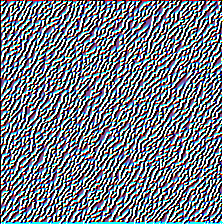

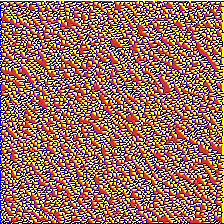

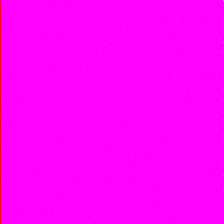

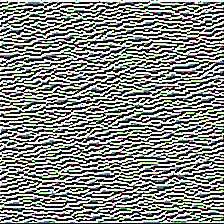

In [0]:
cnn_layer = 1
filter_pos = 5
for i in range(1,5):
  displayfilters(vgg_model,cnn_layer,i)

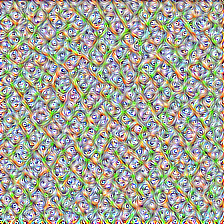

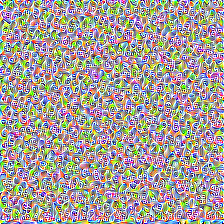

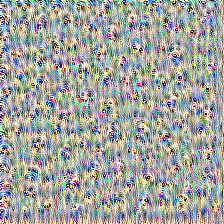

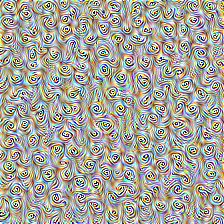

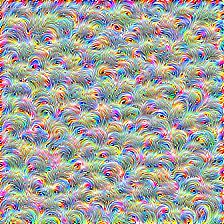

In [0]:
cnn_layer = 17
for i in range(1,6):
  displayfilters(vgg_model,cnn_layer,i)

## Alexnet filters

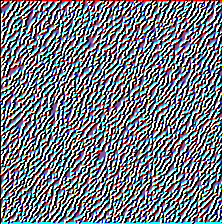

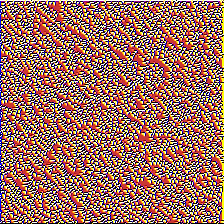

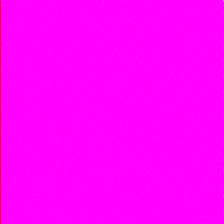

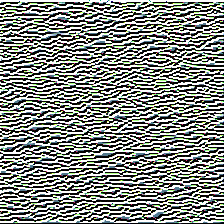

In [0]:
cnn_layer = 1
filter_pos = 5
for i in range(1,5):
  displayfilters(alexnet_model,cnn_layer,i)

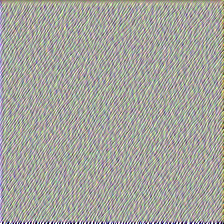

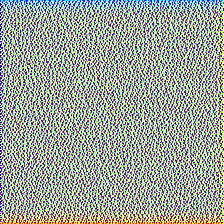

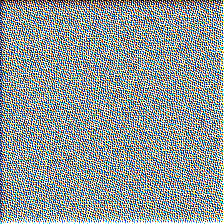

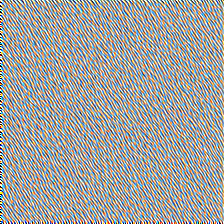

In [0]:
cnn_layer = 5
filter_pos = 5
for i in range(1,5):
  displayfilters(alexnet_model,cnn_layer,i)

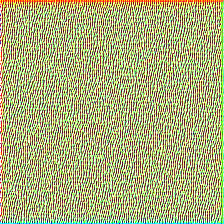

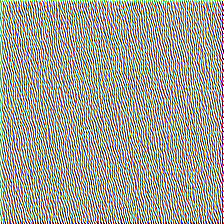

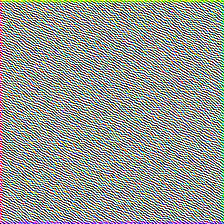

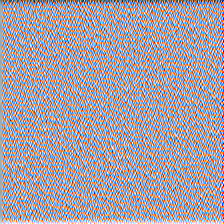

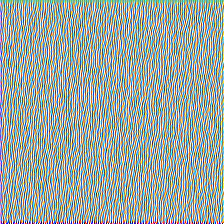

In [0]:
cnn_layer = 5
filter_pos = 5
for i in range(10,15):
  displayfilters(alexnet_model,cnn_layer,i)

# Load cats Vs Dogs dataset
https://www.pluralsight.com/guides/image-classification-with-pytorch


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip -uq "/content/drive/My Drive/kaggle.zip" -d "/content/KaggleImages"

In [0]:
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.image as img
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

%matplotlib inline

In [0]:
labels = pd.read_csv('/content/KaggleImages/train/train.csv')

train_path = '/content/KaggleImages/train/train/'
test_path = '/content/KaggleImages/train/test/'

In [0]:
labels.columns = ['id', 'classes']
labels.head()

,id,classes
0,cat.8010.jpg,0
1,cat.10013.jpg,0
2,cat.11131.jpg,0
3,cat.10323.jpg,0
4,cat.9163.jpg,0


In [0]:
class CatsDogsDataset(Dataset):
    def __init__(self, data, path , transform = None):
        super().__init__()
        self.data = data.values
        self.path = path
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        img_name,label = self.data[index]
        img_path = os.path.join(self.path, img_name)
        image = img.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [0]:
size=224
train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.CenterCrop(size),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) 


valid_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.CenterCrop(size),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) 

train, valid_data = train_test_split(labels, stratify=labels['classes'], test_size=0.2)

train_data = CatsDogsDataset(train, train_path, train_transform )
valid_data = CatsDogsDataset(valid_data, train_path, valid_transform )

# Hyper parameters
num_classes = 2
batch_size = 64

# CPU or GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset = valid_data, batch_size = batch_size, shuffle=False, num_workers=0)

# Helper functions


In [0]:
import os

# Function to train and evaluate the performance of the model
def run_and_evaluate_model(device, model, train_loader, valid_loader, num_epochs, learning_rate):
    device = torch.device("cuda")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # keeping-track-of-losses
    train_losses = []
    valid_losses = []

    for epoch in range(1, num_epochs + 1):
        # keep-track-of-training-and-validation-loss
        train_loss = 0.0
        valid_loss = 0.0

        # training-the-model
        model.train()
        for data, target in train_loader:
            # move-tensors-to-GPU
            data = data.to(device)
            target = target.to(device)

            # clear-the-gradients-of-all-optimized-variables
            optimizer.zero_grad()
            # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
            output = model(data)
            # calculate-the-batch-loss
            loss = criterion(output, target)
            # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
            loss.backward()
            # perform-a-ingle-optimization-step (parameter-update)
            optimizer.step()
            # update-training-loss
            train_loss += loss.item() * data.size(0)

        # validate-the-model
        model.eval()
        for data, target in valid_loader:
            data = data.to(device)
            target = target.to(device)

            output = model(data)

            loss = criterion(output, target)

            # update-average-validation-loss
            valid_loss += loss.item() * data.size(0)

        # calculate-average-losses
        train_loss = train_loss / len(train_loader.sampler)
        valid_loss = valid_loss / len(valid_loader.sampler)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        # print-training/validation-statistics
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))

    # test-the-model
    model.eval()  # it-disables-dropout
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Test Accuracy of the model: {} %'.format(100 * correct / total))


# Helper function to retain layers from AlexNet model and reinitialise other layers to random weights
def retain_layers(model, num_layers_retain):
  total_cnn_layers = 5
  layer_names = ['features.0.weight', 'features.0.bias', 'features.3.weight', 'features.3.bias', 'features.6.weight', 'features.6.bias', 'features.8.weight', 'features.8.bias', 'features.10.weight', 'features.10.bias', 'classifier.1.weight', 'classifier.1.bias', 'classifier.4.weight', 'classifier.4.bias', 'classifier.6.weight', 'classifier.6.bias']
  for i in range(num_layers_retain, total_cnn_layers):
    sd = model.state_dict()
    feature = layer_names[i*2]
    bias = layer_names[(i*2)+1]
    sd[feature].normal_()
    sd[bias].normal_()

# freeze or fine tune weights of n layers
# https://discuss.pytorch.org/t/how-the-pytorch-freeze-network-in-some-layers-only-the-rest-of-the-training/7088
def process_weights(model, start, end, grad_bool):
  i=0
  for param in model.parameters():
    if((i>=start*2) & (i<end*2)):
      param.requires_grad=grad_bool
    i+=1

# Helper function to copy n layers from source model to destination model
# https://discuss.pytorch.org/t/copy-weights-only-from-a-networks-parameters/5841
def copy_layers(num_layers, source, dest):
  layer_names = ['features.0.weight', 'features.0.bias', 'features.3.weight', 'features.3.bias', 'features.6.weight', 'features.6.bias', 'features.8.weight', 'features.8.bias', 'features.10.weight', 'features.10.bias', 'classifier.1.weight', 'classifier.1.bias', 'classifier.4.weight', 'classifier.4.bias', 'classifier.6.weight', 'classifier.6.bias']
  for i in range(0, num_layers):
    source_sd = source.state_dict()
    dest_sd = dest.state_dict()
    feature = layer_names[i*2]
    bias = layer_names[(i*2)+1]
    dest.state_dict()[feature].data.copy_(source.state_dict()[feature].data)
    dest.state_dict()[bias].data.copy_(source.state_dict()[bias].data)
  

# Experiment 1: Train on similar pairs

- Dataset A: Use pretrained weights from AlexNet model trained on 1000 classes which also has cat family in it.
- Dataset B - cats vs dogs Kaggle dataset



## baseB 
AlexNet architecture trained on Cats Vs Dogs dataset(start with random weights)



In [0]:
baseB = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=False)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [0]:
import torch.nn as nn
baseB.classifier[6] = nn.Linear(4096,2)

In [0]:
%%time
import os

# fine tune weights of all layers
for param in baseB.parameters():
    param.requires_grad = True

run_and_evaluate_model(device, baseB, train_loader, valid_loader, 10, 0.0001)

Epoch: 1 	Training Loss: 0.637744 	Validation Loss: 0.565206
Epoch: 2 	Training Loss: 0.551213 	Validation Loss: 0.486575
Epoch: 3 	Training Loss: 0.467945 	Validation Loss: 0.403803
Epoch: 4 	Training Loss: 0.399915 	Validation Loss: 0.368508
Epoch: 5 	Training Loss: 0.363385 	Validation Loss: 0.394250
Epoch: 6 	Training Loss: 0.320510 	Validation Loss: 0.320756
Epoch: 7 	Training Loss: 0.284907 	Validation Loss: 0.296111
Epoch: 8 	Training Loss: 0.250198 	Validation Loss: 0.284210
Epoch: 9 	Training Loss: 0.227215 	Validation Loss: 0.301802
Epoch: 10 	Training Loss: 0.207007 	Validation Loss: 0.290472
Test Accuracy of the model: 88.66 %
CPU times: user 19min 5s, sys: 4min 22s, total: 23min 28s
Wall time: 23min 29s


In [0]:
torch.save(baseB.state_dict(), '/content/baseB.pt')

In [0]:
torch.save(baseB.state_dict(), '/content/drive/My Drive/baseB.pt')

## A selffer network BnB: 
Copy first n layers from baseB (freeze it). Initialize random weights to rest of the 5-n layers and train on dataset B.


In [0]:
# retain n layers and reinitialise weights of others layers randomnly
# layers 1 to 5
for layer in range(1,6):
  bnb = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=False)
  bnb.classifier[6] = nn.Linear(4096,2)
  # load pretrained model baseB
  baseB = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=False)
  baseB.classifier[6] = nn.Linear(4096,2)
  baseB.load_state_dict(torch.load('/content/baseB.pt'))
  print('Starting for BnB model retaining {} layers'.format(layer))
  copy_layers(layer, baseB, bnb)
  # freeze weights of n layers 
  process_weights(bnb, 0, layer, False)
  # fine tune weights of rest of the layers
  process_weights(bnb, layer+1, 4, True)
  # run and evaluate the model
  run_and_evaluate_model(device, bnb, train_loader, valid_loader, 10, 0.0001)
  filename_to_save = '/content/b{}b.pt'.format(layer)
  torch.save(bnb.state_dict(), filename_to_save)
  print('Done for BnB model retaining {} layers'.format(layer))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Starting for BnB model retaining 1 layers
Epoch: 1 	Training Loss: 0.589532 	Validation Loss: 0.495153
Epoch: 2 	Training Loss: 0.447200 	Validation Loss: 0.405460
Epoch: 3 	Training Loss: 0.368963 	Validation Loss: 0.332988
Epoch: 4 	Training Loss: 0.318728 	Validation Loss: 0.319364
Epoch: 5 	Training Loss: 0.275829 	Validation Loss: 0.337379
Epoch: 6 	Training Loss: 0.242921 	Validation Loss: 0.315663
Epoch: 7 	Training Loss: 0.224671 	Validation Loss: 0.282036
Epoch: 8 	Training Loss: 0.193219 	Validation Loss: 0.239311
Epoch: 9 	Training Loss: 0.178112 	Validation Loss: 0.258173
Epoch: 10 	Training Loss: 0.162300 	Validation Loss: 0.270426
Test Accuracy of the model: 88.26 %
Done for BnB model retaining 1 layers


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Starting for BnB model retaining 2 layers
Epoch: 1 	Training Loss: 0.412052 	Validation Loss: 0.333380
Epoch: 2 	Training Loss: 0.278988 	Validation Loss: 0.296388
Epoch: 3 	Training Loss: 0.237101 	Validation Loss: 0.288449
Epoch: 4 	Training Loss: 0.213525 	Validation Loss: 0.262319
Epoch: 5 	Training Loss: 0.192672 	Validation Loss: 0.255807
Epoch: 6 	Training Loss: 0.170237 	Validation Loss: 0.263823
Epoch: 7 	Training Loss: 0.152085 	Validation Loss: 0.275732
Epoch: 8 	Training Loss: 0.138548 	Validation Loss: 0.266952
Epoch: 9 	Training Loss: 0.116431 	Validation Loss: 0.302033
Epoch: 10 	Training Loss: 0.100325 	Validation Loss: 0.275027
Test Accuracy of the model: 89.86 %
Done for BnB model retaining 2 layers


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Starting for BnB model retaining 3 layers
Epoch: 1 	Training Loss: 0.301221 	Validation Loss: 0.313323
Epoch: 2 	Training Loss: 0.191233 	Validation Loss: 0.275082
Epoch: 3 	Training Loss: 0.171066 	Validation Loss: 0.267987
Epoch: 4 	Training Loss: 0.158872 	Validation Loss: 0.299178
Epoch: 5 	Training Loss: 0.140954 	Validation Loss: 0.290376
Epoch: 6 	Training Loss: 0.127916 	Validation Loss: 0.267371
Epoch: 7 	Training Loss: 0.120978 	Validation Loss: 0.289526
Epoch: 8 	Training Loss: 0.107958 	Validation Loss: 0.285314
Epoch: 9 	Training Loss: 0.092864 	Validation Loss: 0.335742
Epoch: 10 	Training Loss: 0.083186 	Validation Loss: 0.341399
Test Accuracy of the model: 90.02 %
Done for BnB model retaining 3 layers


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Starting for BnB model retaining 4 layers
Epoch: 1 	Training Loss: 0.237714 	Validation Loss: 0.273810
Epoch: 2 	Training Loss: 0.172235 	Validation Loss: 0.282654
Epoch: 3 	Training Loss: 0.152712 	Validation Loss: 0.278243
Epoch: 4 	Training Loss: 0.153663 	Validation Loss: 0.270739
Epoch: 5 	Training Loss: 0.142451 	Validation Loss: 0.272843
Epoch: 6 	Training Loss: 0.138961 	Validation Loss: 0.285328
Epoch: 7 	Training Loss: 0.128646 	Validation Loss: 0.289930
Epoch: 8 	Training Loss: 0.119393 	Validation Loss: 0.293517
Epoch: 9 	Training Loss: 0.111263 	Validation Loss: 0.297982
Epoch: 10 	Training Loss: 0.103281 	Validation Loss: 0.369145
Test Accuracy of the model: 88.08 %
Done for BnB model retaining 4 layers


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Starting for BnB model retaining 5 layers
Epoch: 1 	Training Loss: 0.195434 	Validation Loss: 0.270427
Epoch: 2 	Training Loss: 0.160437 	Validation Loss: 0.289919
Epoch: 3 	Training Loss: 0.158014 	Validation Loss: 0.267478
Epoch: 4 	Training Loss: 0.156608 	Validation Loss: 0.271834
Epoch: 5 	Training Loss: 0.149011 	Validation Loss: 0.260921
Epoch: 6 	Training Loss: 0.150541 	Validation Loss: 0.278384
Epoch: 7 	Training Loss: 0.145072 	Validation Loss: 0.283326
Epoch: 8 	Training Loss: 0.143151 	Validation Loss: 0.275561
Epoch: 9 	Training Loss: 0.144783 	Validation Loss: 0.277534
Epoch: 10 	Training Loss: 0.140061 	Validation Loss: 0.289059
Test Accuracy of the model: 88.94 %
Done for BnB model retaining 5 layers


## A selffer network BnB+ 
Copy first n layers from baseB. Initialize random weights to rest of the 5-n layers and train on dataset B. Fine tune all layers. (similar to BnB but the first n layers also learn - fine tuned).

In [0]:
# retain n layers and reinitialise weights of others layers randomnly
# layers 1 to 5
import torch.nn as nn
for layer in range(1,6):
  bnb_plus = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=False)
  bnb_plus.classifier[6] = nn.Linear(4096,2)
  # load pretrained model baseB
  baseB = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=False)
  baseB.classifier[6] = nn.Linear(4096,2)
  baseB.load_state_dict(torch.load('/content/drive/My Drive/baseB.pt'))
  print('Starting for BnB+ model retaining {} layers'.format(layer))
  copy_layers(layer, baseB, bnb_plus)
  # fine tune weights n layers 
  process_weights(bnb_plus, 0, 7, True)
  # run and evaluate the model
  run_and_evaluate_model(device, bnb_plus, train_loader, valid_loader, 10, 0.0001)
  filename_to_save = '/content/b{}b_plus.pt'.format(layer)
  torch.save(bnb_plus.state_dict(), filename_to_save)
  print('Done for BnB+ model retaining {} layers'.format(layer))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Starting for BnB+ model retaining 1 layers
Epoch: 1 	Training Loss: 0.589587 	Validation Loss: 0.512487
Epoch: 2 	Training Loss: 0.448498 	Validation Loss: 0.463368
Epoch: 3 	Training Loss: 0.370550 	Validation Loss: 0.335956
Epoch: 4 	Training Loss: 0.317403 	Validation Loss: 0.350193
Epoch: 5 	Training Loss: 0.277443 	Validation Loss: 0.322709
Epoch: 6 	Training Loss: 0.247494 	Validation Loss: 0.265882
Epoch: 7 	Training Loss: 0.221237 	Validation Loss: 0.374590
Epoch: 8 	Training Loss: 0.201461 	Validation Loss: 0.276919
Epoch: 9 	Training Loss: 0.185629 	Validation Loss: 0.273070
Epoch: 10 	Training Loss: 0.161459 	Validation Loss: 0.255688
Test Accuracy of the model: 90.38 %
Done for BnB+ model retaining 1 layers


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Starting for BnB+ model retaining 2 layers
Epoch: 1 	Training Loss: 0.454023 	Validation Loss: 0.355175
Epoch: 2 	Training Loss: 0.320311 	Validation Loss: 0.356163
Epoch: 3 	Training Loss: 0.271721 	Validation Loss: 0.267823
Epoch: 4 	Training Loss: 0.240043 	Validation Loss: 0.272047
Epoch: 5 	Training Loss: 0.213833 	Validation Loss: 0.229677
Epoch: 6 	Training Loss: 0.199220 	Validation Loss: 0.303319
Epoch: 7 	Training Loss: 0.179762 	Validation Loss: 0.259940
Epoch: 8 	Training Loss: 0.167909 	Validation Loss: 0.251242
Epoch: 9 	Training Loss: 0.151535 	Validation Loss: 0.274372
Epoch: 10 	Training Loss: 0.133218 	Validation Loss: 0.243327
Test Accuracy of the model: 90.54 %
Done for BnB+ model retaining 2 layers


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Starting for BnB+ model retaining 3 layers
Epoch: 1 	Training Loss: 0.336355 	Validation Loss: 0.261463
Epoch: 2 	Training Loss: 0.236556 	Validation Loss: 0.225064
Epoch: 3 	Training Loss: 0.213572 	Validation Loss: 0.221664
Epoch: 4 	Training Loss: 0.180006 	Validation Loss: 0.206216
Epoch: 5 	Training Loss: 0.168452 	Validation Loss: 0.225036
Epoch: 6 	Training Loss: 0.149342 	Validation Loss: 0.227628
Epoch: 7 	Training Loss: 0.140446 	Validation Loss: 0.228019
Epoch: 8 	Training Loss: 0.120190 	Validation Loss: 0.231299
Epoch: 9 	Training Loss: 0.116431 	Validation Loss: 0.244923
Epoch: 10 	Training Loss: 0.102813 	Validation Loss: 0.235891
Test Accuracy of the model: 90.46 %
Done for BnB+ model retaining 3 layers


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Starting for BnB+ model retaining 4 layers
Epoch: 1 	Training Loss: 0.280518 	Validation Loss: 0.303413
Epoch: 2 	Training Loss: 0.210153 	Validation Loss: 0.222308
Epoch: 3 	Training Loss: 0.189364 	Validation Loss: 0.230899
Epoch: 4 	Training Loss: 0.173242 	Validation Loss: 0.213975
Epoch: 5 	Training Loss: 0.154907 	Validation Loss: 0.216714
Epoch: 6 	Training Loss: 0.137838 	Validation Loss: 0.204756
Epoch: 7 	Training Loss: 0.123023 	Validation Loss: 0.217752
Epoch: 8 	Training Loss: 0.112168 	Validation Loss: 0.238508
Epoch: 9 	Training Loss: 0.099096 	Validation Loss: 0.222311
Epoch: 10 	Training Loss: 0.089305 	Validation Loss: 0.216878
Test Accuracy of the model: 91.68 %
Done for BnB+ model retaining 4 layers


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Starting for BnB+ model retaining 5 layers
Epoch: 1 	Training Loss: 0.251807 	Validation Loss: 0.197138
Epoch: 2 	Training Loss: 0.195547 	Validation Loss: 0.229731
Epoch: 3 	Training Loss: 0.174059 	Validation Loss: 0.241781
Epoch: 4 	Training Loss: 0.161160 	Validation Loss: 0.232894
Epoch: 5 	Training Loss: 0.142501 	Validation Loss: 0.205531
Epoch: 6 	Training Loss: 0.124503 	Validation Loss: 0.210309
Epoch: 7 	Training Loss: 0.111700 	Validation Loss: 0.198145
Epoch: 8 	Training Loss: 0.106472 	Validation Loss: 0.211181
Epoch: 9 	Training Loss: 0.088697 	Validation Loss: 0.220313
Epoch: 10 	Training Loss: 0.086696 	Validation Loss: 0.239889
Test Accuracy of the model: 92.12 %
Done for BnB+ model retaining 5 layers


## A transfer network AnB
copy first n layers from baseA (freeze it). Initialize random weights to rest of the 8-n layers and train on dataset B. Similarly for BnA

In [0]:
# retain n layers and reinitialise weights of others layers randomnly
# layers 1 to 5
device = torch.device("cuda")
for layer in range(1,6):
  print('Starting for AnB model retaining {} layers'.format(layer))
  baseA = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
  baseA.classifier[6] = nn.Linear(4096,2)
  anb = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=False)
  anb.classifier[6] = nn.Linear(4096,2)
  copy_layers(layer, baseA, anb)
  # freeze weights of n layers 
  process_weights(anb, 0, layer, False)
  # fine tune weights of rest of the layers
  process_weights(anb, layer+1, 7, True)
  # run and evaluate the model
  run_and_evaluate_model(device, anb, train_loader, valid_loader, 10, 0.0001)
  filename_to_save = '/content/a{}b.pt'.format(layer)
  torch.save(anb.state_dict(), filename_to_save)
  print('Done for AnB model retaining {} layers'.format(layer))

Starting for AnB model retaining 1 layers


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch: 1 	Training Loss: 0.540109 	Validation Loss: 0.405835
Epoch: 2 	Training Loss: 0.346371 	Validation Loss: 0.359980
Epoch: 3 	Training Loss: 0.274060 	Validation Loss: 0.281402
Epoch: 4 	Training Loss: 0.222029 	Validation Loss: 0.250785
Epoch: 5 	Training Loss: 0.184636 	Validation Loss: 0.221739
Epoch: 6 	Training Loss: 0.158299 	Validation Loss: 0.200659
Epoch: 7 	Training Loss: 0.138603 	Validation Loss: 0.225917
Epoch: 8 	Training Loss: 0.119452 	Validation Loss: 0.233823
Epoch: 9 	Training Loss: 0.106409 	Validation Loss: 0.207675
Epoch: 10 	Training Loss: 0.097593 	Validation Loss: 0.195813
Test Accuracy of the model: 92.12 %
Done for AnB model retaining 1 layers
Starting for AnB model retaining 2 layers


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch: 1 	Training Loss: 0.396531 	Validation Loss: 0.241753
Epoch: 2 	Training Loss: 0.221975 	Validation Loss: 0.190527
Epoch: 3 	Training Loss: 0.157403 	Validation Loss: 0.164378
Epoch: 4 	Training Loss: 0.131960 	Validation Loss: 0.155530
Epoch: 5 	Training Loss: 0.107309 	Validation Loss: 0.163098
Epoch: 6 	Training Loss: 0.089475 	Validation Loss: 0.152781
Epoch: 7 	Training Loss: 0.077577 	Validation Loss: 0.163050
Epoch: 8 	Training Loss: 0.070952 	Validation Loss: 0.158271
Epoch: 9 	Training Loss: 0.056867 	Validation Loss: 0.159212
Epoch: 10 	Training Loss: 0.049692 	Validation Loss: 0.158054
Test Accuracy of the model: 94.34 %
Done for AnB model retaining 2 layers
Starting for AnB model retaining 3 layers


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch: 1 	Training Loss: 0.295936 	Validation Loss: 0.167181
Epoch: 2 	Training Loss: 0.147280 	Validation Loss: 0.171625
Epoch: 3 	Training Loss: 0.109137 	Validation Loss: 0.122560
Epoch: 4 	Training Loss: 0.079838 	Validation Loss: 0.124662
Epoch: 5 	Training Loss: 0.061834 	Validation Loss: 0.143300
Epoch: 6 	Training Loss: 0.050443 	Validation Loss: 0.136284
Epoch: 7 	Training Loss: 0.043777 	Validation Loss: 0.140590
Epoch: 8 	Training Loss: 0.037119 	Validation Loss: 0.127019
Epoch: 9 	Training Loss: 0.028162 	Validation Loss: 0.180374
Epoch: 10 	Training Loss: 0.031836 	Validation Loss: 0.161716
Test Accuracy of the model: 95.42 %
Done for AnB model retaining 3 layers
Starting for AnB model retaining 4 layers


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch: 1 	Training Loss: 0.247439 	Validation Loss: 0.181110
Epoch: 2 	Training Loss: 0.127064 	Validation Loss: 0.128596
Epoch: 3 	Training Loss: 0.091080 	Validation Loss: 0.115771
Epoch: 4 	Training Loss: 0.069392 	Validation Loss: 0.123843
Epoch: 5 	Training Loss: 0.058989 	Validation Loss: 0.154962
Epoch: 6 	Training Loss: 0.045749 	Validation Loss: 0.155825
Epoch: 7 	Training Loss: 0.038441 	Validation Loss: 0.148846
Epoch: 8 	Training Loss: 0.028379 	Validation Loss: 0.186449
Epoch: 9 	Training Loss: 0.026207 	Validation Loss: 0.181638
Epoch: 10 	Training Loss: 0.025057 	Validation Loss: 0.171235
Test Accuracy of the model: 95.76 %
Done for AnB model retaining 4 layers
Starting for AnB model retaining 5 layers


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch: 1 	Training Loss: 0.191547 	Validation Loss: 0.131285
Epoch: 2 	Training Loss: 0.142635 	Validation Loss: 0.131875
Epoch: 3 	Training Loss: 0.129214 	Validation Loss: 0.125609


## A transfer network AnB+
copy first n layers from baseA. Initialize random weights to rest of the 8-n layers and train on dataset B. All layers learn


In [0]:
# retain n layers and reinitialise weights of others layers randomnly
# layers 1 to 5
for layer in range(1,6):
  print('Starting for AnB+ model retaining {} layers'.format(layer))
  baseA = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
  baseA.classifier[6] = nn.Linear(4096,2)
  anb_plus = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=False)
  anb_plus.classifier[6] = nn.Linear(4096,2)
  copy_layers(layer, baseA, anb_plus)
  # fine tune weights of all the layers
  process_weights(anb_plus, 0, 7, True)
  # run and evaluate the model
  run_and_evaluate_model(device, anb_plus, train_loader, valid_loader, 10, 0.0001)
  filename_to_save = '/content/a{}b_plus.pt'.format(layer)
  torch.save(anb_plus.state_dict(), filename_to_save)
  print('Done for AnB+ model retaining {} layers'.format(layer))

Starting for AnB+ model retaining 1 layers


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch: 1 	Training Loss: 0.540102 	Validation Loss: 0.435978
Epoch: 2 	Training Loss: 0.376330 	Validation Loss: 0.289890
Epoch: 3 	Training Loss: 0.288823 	Validation Loss: 0.267015
Epoch: 4 	Training Loss: 0.234938 	Validation Loss: 0.254160
Epoch: 5 	Training Loss: 0.197645 	Validation Loss: 0.222235
Epoch: 6 	Training Loss: 0.171155 	Validation Loss: 0.282656
Epoch: 7 	Training Loss: 0.145379 	Validation Loss: 0.195860
Epoch: 8 	Training Loss: 0.132656 	Validation Loss: 0.183249
Epoch: 9 	Training Loss: 0.114516 	Validation Loss: 0.190224
Epoch: 10 	Training Loss: 0.098854 	Validation Loss: 0.202404
Test Accuracy of the model: 92.76 %
Done for AnB+ model retaining 1 layers
Starting for AnB+ model retaining 2 layers


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch: 1 	Training Loss: 0.422621 	Validation Loss: 0.236330
Epoch: 2 	Training Loss: 0.225053 	Validation Loss: 0.168417
Epoch: 3 	Training Loss: 0.160698 	Validation Loss: 0.208771
Epoch: 4 	Training Loss: 0.133372 	Validation Loss: 0.139041
Epoch: 5 	Training Loss: 0.104261 	Validation Loss: 0.139929
Epoch: 6 	Training Loss: 0.084357 	Validation Loss: 0.192645
Epoch: 7 	Training Loss: 0.072295 	Validation Loss: 0.144538
Epoch: 8 	Training Loss: 0.064099 	Validation Loss: 0.171884
Epoch: 9 	Training Loss: 0.052411 	Validation Loss: 0.166110
Epoch: 10 	Training Loss: 0.043140 	Validation Loss: 0.171948
Test Accuracy of the model: 94.5 %
Done for AnB+ model retaining 2 layers
Starting for AnB+ model retaining 3 layers


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch: 1 	Training Loss: 0.318965 	Validation Loss: 0.231427
Epoch: 2 	Training Loss: 0.149066 	Validation Loss: 0.159910
Epoch: 3 	Training Loss: 0.108093 	Validation Loss: 0.112912
Epoch: 4 	Training Loss: 0.082480 	Validation Loss: 0.118151
Epoch: 5 	Training Loss: 0.073235 	Validation Loss: 0.115011
Epoch: 6 	Training Loss: 0.059267 	Validation Loss: 0.143417
Epoch: 7 	Training Loss: 0.048083 	Validation Loss: 0.173901
Epoch: 8 	Training Loss: 0.051643 	Validation Loss: 0.126343
Epoch: 9 	Training Loss: 0.035494 	Validation Loss: 0.195770
Epoch: 10 	Training Loss: 0.031177 	Validation Loss: 0.164673
Test Accuracy of the model: 95.66 %
Done for AnB+ model retaining 3 layers
Starting for AnB+ model retaining 4 layers


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch: 1 	Training Loss: 0.257331 	Validation Loss: 0.124893
Epoch: 2 	Training Loss: 0.118726 	Validation Loss: 0.103534
Epoch: 3 	Training Loss: 0.085872 	Validation Loss: 0.102928
Epoch: 4 	Training Loss: 0.064825 	Validation Loss: 0.094144
Epoch: 5 	Training Loss: 0.054935 	Validation Loss: 0.105071
Epoch: 6 	Training Loss: 0.043471 	Validation Loss: 0.122495
Epoch: 7 	Training Loss: 0.038367 	Validation Loss: 0.144411
Epoch: 8 	Training Loss: 0.030553 	Validation Loss: 0.099545
Epoch: 9 	Training Loss: 0.029860 	Validation Loss: 0.134186
Epoch: 10 	Training Loss: 0.028146 	Validation Loss: 0.317503
Test Accuracy of the model: 93.36 %
Done for AnB+ model retaining 4 layers
Starting for AnB+ model retaining 5 layers


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch: 1 	Training Loss: 0.187743 	Validation Loss: 0.121853
Epoch: 2 	Training Loss: 0.110415 	Validation Loss: 0.107788
Epoch: 3 	Training Loss: 0.076421 	Validation Loss: 0.113530
Epoch: 4 	Training Loss: 0.071073 	Validation Loss: 0.096590
Epoch: 5 	Training Loss: 0.050852 	Validation Loss: 0.130476
Epoch: 6 	Training Loss: 0.047339 	Validation Loss: 0.116180
Epoch: 7 	Training Loss: 0.042886 	Validation Loss: 0.101026
Epoch: 8 	Training Loss: 0.028816 	Validation Loss: 0.112107
Epoch: 9 	Training Loss: 0.028548 	Validation Loss: 0.125190
Epoch: 10 	Training Loss: 0.027232 	Validation Loss: 0.112720
Test Accuracy of the model: 95.96 %
Done for AnB+ model retaining 5 layers


In [0]:
# retain n layers and reinitialise weights of others layers randomnly
# layers 1 to 5
for layer in range(3,6):
  print('Starting for AnB+ model retaining {} layers'.format(layer))
  baseA = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
  baseA.classifier[6] = nn.Linear(4096,2)
  anb_plus = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=False)
  anb_plus.classifier[6] = nn.Linear(4096,2)
  copy_layers(layer, baseA, anb_plus)
  # fine tune weights of all the layers
  process_weights(anb_plus, 0, 7, True)
  # run and evaluate the model
  run_and_evaluate_model(device, anb_plus, train_loader, valid_loader, 10, 0.0001)
  filename_to_save = '/content/a{}b_plus.pt'.format(layer)
  torch.save(anb_plus.state_dict(), filename_to_save)
  print('Done for AnB+ model retaining {} layers'.format(layer))

Starting for AnB+ model retaining 3 layers


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch: 1 	Training Loss: 0.285482 	Validation Loss: 0.161552
Epoch: 2 	Training Loss: 0.143778 	Validation Loss: 0.145730
Epoch: 3 	Training Loss: 0.113483 	Validation Loss: 0.123454
Epoch: 4 	Training Loss: 0.090740 	Validation Loss: 0.158317
Epoch: 5 	Training Loss: 0.070960 	Validation Loss: 0.301057
Epoch: 6 	Training Loss: 0.062500 	Validation Loss: 0.128041
Epoch: 7 	Training Loss: 0.051850 	Validation Loss: 0.134447
Epoch: 8 	Training Loss: 0.045256 	Validation Loss: 0.163659
Epoch: 9 	Training Loss: 0.036383 	Validation Loss: 0.181858
Epoch: 10 	Training Loss: 0.040156 	Validation Loss: 0.155367
Test Accuracy of the model: 95.36 %
Done for AnB+ model retaining 3 layers
Starting for AnB+ model retaining 4 layers


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch: 1 	Training Loss: 0.261226 	Validation Loss: 0.131179
Epoch: 2 	Training Loss: 0.120589 	Validation Loss: 0.120253
Epoch: 3 	Training Loss: 0.084766 	Validation Loss: 0.108078
Epoch: 4 	Training Loss: 0.066794 	Validation Loss: 0.224066
Epoch: 5 	Training Loss: 0.054949 	Validation Loss: 0.124475
Epoch: 6 	Training Loss: 0.042069 	Validation Loss: 0.146986
Epoch: 7 	Training Loss: 0.033339 	Validation Loss: 0.173326
Epoch: 8 	Training Loss: 0.029793 	Validation Loss: 0.212148
Epoch: 9 	Training Loss: 0.027076 	Validation Loss: 0.195579
Epoch: 10 	Training Loss: 0.023985 	Validation Loss: 0.179200
Test Accuracy of the model: 95.68 %
Done for AnB+ model retaining 4 layers
Starting for AnB+ model retaining 5 layers


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch: 1 	Training Loss: 0.180994 	Validation Loss: 0.125146
Epoch: 2 	Training Loss: 0.109112 	Validation Loss: 0.106553
Epoch: 3 	Training Loss: 0.079657 	Validation Loss: 0.106136
Epoch: 4 	Training Loss: 0.063171 	Validation Loss: 0.106348
Epoch: 5 	Training Loss: 0.057430 	Validation Loss: 0.111084
Epoch: 6 	Training Loss: 0.044447 	Validation Loss: 0.110951
Epoch: 7 	Training Loss: 0.041719 	Validation Loss: 0.112638
Epoch: 8 	Training Loss: 0.033792 	Validation Loss: 0.170931
Epoch: 9 	Training Loss: 0.027299 	Validation Loss: 0.106596
Epoch: 10 	Training Loss: 0.029929 	Validation Loss: 0.153035
Test Accuracy of the model: 95.84 %
Done for AnB+ model retaining 5 layers
